In [1]:
# import initialize
import datetime
import numpy as np # type: ignore
import matplotlib as mpl # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import axes3d
import matplotlib.font_manager as fm
import matplotlib.gridspec as gs
from scipy.signal import welch # type: ignore
from scipy.signal.windows import hamming # type: ignore
from scipy.signal import welch # type: ignore
from scipy.signal.windows import hamming # type: ignore
import acquisition
import postNavigation
import tracking
import ephemeris
from geoFunctions import satpos, leastSquarePos, cart2geo, findUtmZone, cart2utm

fileNameStr='C:\Repository\Scripts_general\SoftGNSS-python\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
# Check the number of arguments ==========================================
if fileNameStr is None:
    # fileNameStr = self.fileName
    if not isinstance(fileNameStr, str):
         raise TypeError('File name must be a string')

Importing functions from ./geoFunctions/


In [2]:
# settings = initialize.Settings()
msToProcess = 37000.0
numberOfChannels = 8
skipNumberOfBytes = 0
fileName = fileNameStr
dataType = 'int8'
IF = 9548000.0
samplingFreq = 38192000.0
codeFreqBasis = 1023000.0
codeLength = 1023
skipAcquisition = False
acqSatelliteList = range(1, 33)
acqSearchBand = 14.0
acqThreshold = 2.5
dllDampingRatio = 0.7
dllNoiseBandwidth = 2.0
dllCorrelatorSpacing = 0.5
pllDampingRatio = 0.7
pllNoiseBandwidth = 25.0
navSolPeriod = 500.0
elevationMask = 10.0
useTropCorr = True
plotTracking = True
c = 299792458.0
startOffset = 68.802

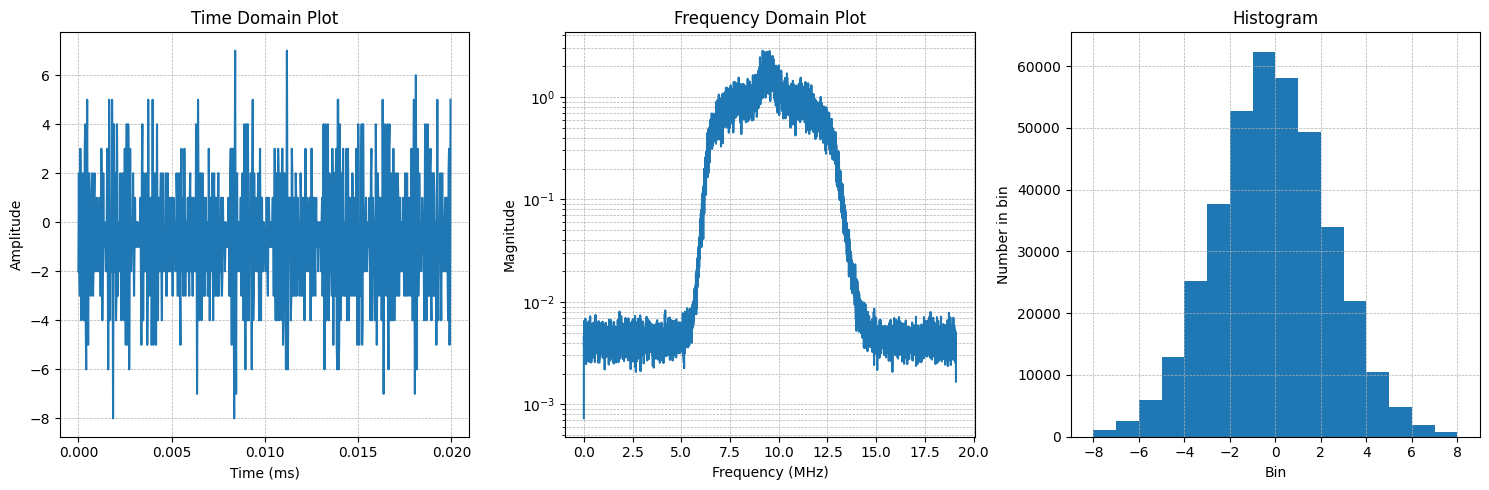

In [3]:
try:
        with open(fileNameStr, 'rb') as fid:
                fid.seek(skipNumberOfBytes, 0)
                samplesPerCode = np.int64(np.round(samplingFreq / (codeFreqBasis / codeLength)))
                try:
                        data = np.fromfile(fid, dataType, 10 * samplesPerCode)
                except IOError:
                    # The file is too short
                    print('Could not read enough data from the data file.')
except IOError as e:
        print('Unable to read file "%s": %s' % (fileNameStr, e))

timeScale = np.arange(0, 0.05, 1 / samplingFreq)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primeiro subplot: Domínio do Tempo
axs[0].plot(1000 * timeScale[:int(samplesPerCode / 50)], data[:int(samplesPerCode / 50)])
axs[0].set_title('Time Domain Plot')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
axs[0].set_xticks(np.arange(0, 0.025, 0.005)) # type: ignore

# Segundo subplot: Domínio da Frequência
f, Pxx = welch(data - np.mean(data), samplingFreq / 1e6, hamming(16384, False), 16384, 1024, 16384) # type: ignore
axs[1].semilogy(f, Pxx)
axs[1].set_title('Frequency Domain Plot')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Terceiro subplot: Histograma
dmax = np.max(np.abs(data)) + 1 # type: ignore
axs[2].hist(data, bins=np.arange(-128, 128))
axs[2].set_title('Histogram')
axs[2].set_xlabel('Bin')
axs[2].set_ylabel('Number in bin')
axs[2].set_xlim([-dmax, dmax])
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Ajustar layout
plt.tight_layout()
plt.show()

In [6]:
print('Starting processing...')
if not fileNameStr:
    fileNameStr = fileName
if not isinstance(fileNameStr, str):
    raise TypeError('File name must be a string')
with open(fileNameStr, 'rb') as fid:
    fid.seek(skipNumberOfBytes, 0)
    if not skipAcquisition:  # or 'acqResults' not in globals():
    # Find number of samples per spreading code
        samplesPerCode = samplesPerCode
        # frequency estimation
        data = np.fromfile(fid, dataType, 11 * samplesPerCode)
# Find sampling period
ts = 1.0 / samplingFreq
# Find phase points of the local carrier wave
phasePoints = np.arange(samplesPerCode) * 2 * np.pi * ts
# Number of the frequency bins for the given acquisition band (500Hz steps)
numberOfFrqBins = np.int64(np.round(acqSearchBand * 2) + 1)

Starting processing...


In [ ]:
def generateCAcode(prn):
        assert prn in range(0, 32)
        g2s = [5, 6, 7, 8, 17, 18, 139, 140, 141, 251,
               252, 254, 255, 256, 257, 258, 469, 470, 471, 472,
               473, 474, 509, 512, 513, 514, 515, 516, 859, 860,
               861, 862,
               145, 175, 52, 21, 237, 235, 886, 657, 634, 762, 355, 1012, 176, 603, 130, 359, 595, 68, 386]

        # --- Pick right shift for the given PRN number ----------------------------
        g2shift = g2s[prn]

        # --- Generate G1 code -----------------------------------------------------

        # --- Initialize g1 output to speed up the function ---
        g1 = np.zeros(1023)

        # --- Load shift register ---
        reg = -1 * np.ones(10)

        # --- Generate all G1 signal chips based on the G1 feedback polynomial -----
        for i in range(1023):
            g1[i] = reg[-1]

            saveBit = reg[2] * reg[9]

            reg[1:] = reg[:-1]

            reg[0] = saveBit

        # --- Generate G2 code -----------------------------------------------------

        # --- Initialize g2 output to speed up the function ---
        g2 = np.zeros(1023)

        # --- Load shift register ---
        reg = -1 * np.ones(10)

        # --- Generate all G2 signal chips based on the G2 feedback polynomial -----
        for i in range(1023):
            g2[i] = reg[-1]

            saveBit = reg[1] * reg[2] * reg[5] * reg[7] * reg[8] * reg[9]

            reg[1:] = reg[:-1]

            reg[0] = saveBit

        # --- Shift G2 code --------------------------------------------------------
        # The idea: g2 = concatenate[ g2_right_part, g2_left_part ];
        g2 = np.r_[g2[1023 - g2shift:], g2[:1023 - g2shift]]

        # --- Form single sample C/A code by multiplying G1 and G2 -----------------
        CAcode = -g1 * g2
        
        return CAcode

In [14]:
# samplesPerCode
caCodesTable = np.zeros((32, samplesPerCode))
# --- Find time constants --------------------------------------------------
ts = 1.0 / samplingFreq
tc = 1.0 / codeFreqBasis

# === For all satellite PRN-s ...
for PRN in range(32):
    # --- Generate CA code for given PRN -----------------------------------
    caCode = generateCAcode(PRN)

    # --- Make index array to read C/A code values -------------------------
    # The length of the index array depends on the sampling frequency -
    # number of samples per millisecond (because one C/A code period is one millisecond).
    codeValueIndex = np.ceil(ts * np.arange(1, samplesPerCode + 1) / tc) - 1
    codeValueIndex = np.longlong(codeValueIndex)
    codeValueIndex[-1] = 1022

    # The "upsampled" code is made by selecting values form the CA code 
    # chip array (caCode) for the time instances of each sample.
    caCodesTable[PRN] = caCode[codeValueIndex]

In [ ]:




# Generate all C/A codes and sample them according to the sampling freq.
caCodesTable = settings.makeCaTable()


'C:\\Repository\\Scripts_general\\SoftGNSS-python\\GNSS_signal_records\\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'

In [ ]:
# --- Initialize arrays to speed up the code -------------------------------
# Search results of all frequency bins and code shifts (for one satellite)
results = np.zeros((numberOfFrqBins, samplesPerCode))
# Carrier frequencies of the frequency bins
frqBins = np.zeros(numberOfFrqBins)
# --- Initialize acqResults ------------------------------------------------
# Carrier frequencies of detected signals
carrFreq = np.zeros(32)
# C/A code phases of detected signals
codePhase_ = np.zeros(32)
# Correlation peak ratios of the detected signals
peakMetric = np.zeros(32)
print(' Perform search for all listed PRN numbers ...')

In [ ]:

samplesPerCode = settings.samplesPerCode
longSignal = data
# Create two 1m sec vectors of data to correlate with and one with zero DC
signal1 = longSignal[0:samplesPerCode]
signal2 = longSignal[samplesPerCode:2 * samplesPerCode]
signal0DC = longSignal - longSignal.mean()

for PRN in range(len(settings.acqSatelliteList)):
    # Correlate signals ======================================================
    # --- Perform DFT of C/A code ------------------------------------------
    caCodeFreqDom = np.fft.fft(caCodesTable[PRN, :]).conj()
    for frqBinIndex in range(numberOfFrqBins):
        # --- Generate carrier wave frequency grid (0.5kHz step) -----------
        frqBins[frqBinIndex] = settings.IF - settings.acqSearchBand / 2 * 1000 + 500.0 * frqBinIndex
        sinCarr = np.sin(frqBins[frqBinIndex] * phasePoints)
        cosCarr = np.cos(frqBins[frqBinIndex] * phasePoints)
        I1 = sinCarr * signal1
        Q1 = cosCarr * signal1
        I2 = sinCarr * signal2
        Q2 = cosCarr * signal2
        IQfreqDom1 = np.fft.fft(I1 + 1j * Q1)
        IQfreqDom2 = np.fft.fft(I2 + 1j * Q2)
        # domain
        convCodeIQ1 = IQfreqDom1 * caCodeFreqDom
        convCodeIQ2 = IQfreqDom2 * caCodeFreqDom
        acqRes1 = abs(np.fft.ifft(convCodeIQ1)) ** 2
        acqRes2 = abs(np.fft.ifft(convCodeIQ2)) ** 2

        # "blend" 1st and 2nd msec but will correct data bit issues
        if acqRes1.max() > acqRes2.max():
            results[frqBinIndex, :] = acqRes1
        else:
            results[frqBinIndex, :] = acqRes2

    # Look for correlation peaks in the results ==============================
    # Find the highest peak and compare it to the second highest peak
    # The second peak is chosen not closer than 1 chip to the highest peak
    # --- Find the correlation peak and the carrier frequency --------------
    peakSize = results.max(1).max()
    frequencyBinIndex = results.max(1).argmax()
    peakSize = results.max(0).max()
    codePhase = results.max(0).argmax()
    samplesPerCodeChip = np.int64(round(settings.samplingFreq / settings.codeFreqBasis))
    excludeRangeIndex1 = codePhase - samplesPerCodeChip
    excludeRangeIndex2 = codePhase + samplesPerCodeChip
    # boundaries
    if excludeRangeIndex1 <= 0:
        codePhaseRange = np.r_[excludeRangeIndex2:samplesPerCode + excludeRangeIndex1 + 1]
    elif excludeRangeIndex2 >= samplesPerCode - 1:
        codePhaseRange = np.r_[excludeRangeIndex2 - samplesPerCode:excludeRangeIndex1]
    else:
        codePhaseRange = np.r_[0:excludeRangeIndex1 + 1, excludeRangeIndex2:samplesPerCode]
    # --- Find the second highest correlation peak in the same freq. bin ---
    secondPeakSize = results[frequencyBinIndex, codePhaseRange].max()
    peakMetric[PRN] = peakSize / secondPeakSize

    if (peakSize / secondPeakSize) > settings.acqThreshold:
    # Fine resolution frequency search =======================================
    # --- Indicate PRN number of the detected signal -------------------
        print('%02d' % (PRN + 1), end=' ')  # Saída na mesma linha
        caCode = settings.generateCAcode(PRN)
        codeValueIndex = np.floor(ts * np.arange(1, 10 * samplesPerCode + 1) / (1.0 / settings.codeFreqBasis))
        longCaCode = caCode[np.longlong(codeValueIndex % 1023)]
        # (Using detected C/A code phase)
        xCarrier = signal0DC[codePhase:codePhase + 10 * samplesPerCode] * longCaCode
        fftNumPts = 8 * 2 ** (np.ceil(np.log2(len(xCarrier))))
        # associated carrier frequency
        fftxc = np.abs(np.fft.fft(xCarrier, np.int64(fftNumPts)))
        uniqFftPts = np.int64(np.ceil((fftNumPts + 1) / 2.0))
        fftMax = fftxc[4:uniqFftPts - 5].max()
        fftMaxIndex = fftxc[4:uniqFftPts - 5].argmax()
        fftFreqBins = np.arange(uniqFftPts) * settings.samplingFreq / fftNumPts
        carrFreq[PRN] = fftFreqBins[fftMaxIndex]
        codePhase_[PRN] = codePhase
    else:
        # --- No signal with this PRN --------------------------------------
        print('. ', end=' ')  # Saída na mesma linha para os que falharam
# === Acquisition is over ==================================================
acqResults = np.core.records.fromarrays([carrFreq, codePhase_, peakMetric], names='carrFreq,codePhase,peakMetric')
acqResults._results = acqResults
assert isinstance(acqResults._results, np.recarray)
# Plot all results =======================================================
f, hAxes = plt.subplots()

# Plot barra para peakMetric
plt.bar(range(1, 33), acqResults.peakMetric)
plt.title('Acquisition results')
plt.xlabel('PRN number (no bar - SV is not in the acquisition list)')
plt.ylabel('Acquisition Metric ($1^{st}$ to $2^{nd}$ Correlation Peaks Ratio')

oldAxis = plt.axis()
plt.axis([0, 33, 0, oldAxis[-1]])
plt.xticks(range(1, 33), size=12)

# Mark acquired signals ==================================================
acquiredSignals = acqResults.peakMetric * (acqResults.carrFreq > 0)

# Alterar ticks do eixo X corretamente
hAxes.set_xticks(np.arange(0, 33, 5))  # Modifiquei para hAxes.set_xticks() que é o correto

# Plot barra para sinais adquiridos
plt.bar(range(1, 33), acquiredSignals, color=(0, 0.8, 0))

# Adicionar legenda
plt.legend(['Not acquired signals', 'Acquired signals'])

# Adicionar grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

if np.any(acqResults.carrFreq): # type: ignore
    assert isinstance(acqResults._results, np.recarray)
    # Initializes tracking channels from acquisition data. The acquired
    # signals are sorted according to the signal strength. This function can be
    # modified to use other satellite selection algorithms or to introduce
    # acquired signal properties offsets for testing purposes.
    # Inputs ================================================
    # acqResults  - results from acquisition.
    # settings    - receiver settings
    # Outputs ================================================
    # channel     - structure contains information for each channel (like
    # properties of the tracked signal, channel status etc.).
    # Initialize all channels ================================================
    PRN = np.zeros(settings.numberOfChannels, dtype='int64')
    acquiredFreq = np.zeros(settings.numberOfChannels)
    codePhase = np.zeros(settings.numberOfChannels)
    status = ['-' for _ in range(settings.numberOfChannels)]
    # --- Copy initial data to all channels ------------------------------------
    # Copy acquisition results ===============================================
    # --- Sort peaks to find strongest signals, keep the peak index information
    PRNindexes = sorted(enumerate(acqResults.peakMetric), key=lambda x: x[-1], reverse=True)
    # --- Load information about each satellite --------------------------------
    # Maximum number of initialized channels is number of detected signals, but
    # not more as the number of channels specified in the settings.
    for ii in range(min(settings.numberOfChannels, sum(acqResults.carrFreq > 0))):
        PRN[ii] = PRNindexes[ii][0] + 1
        acquiredFreq[ii] = acqResults.carrFreq[PRNindexes[ii][0]]
        codePhase[ii] = acqResults.codePhase[PRNindexes[ii][0]]
        status[ii] = 'T'
    channel = np.core.records.fromarrays([PRN, acquiredFreq, codePhase, status],
                                     names='PRN,acquiredFreq,codePhase,status')
    acqResults._channels = channel
    # Prints the status of all channels in a table.
    # Inputs ================================================
    # channel - data for each channel. It is used to initialize and
    # at the processing of the signal (tracking part).
    # settings    - receiver settings
    channel = acqResults._channels
    # settings = self._settings
    assert isinstance(channel, np.recarray)
    print ('\n*=========*=====*===============*===========*=============*========*')
    print ('| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |')
    print ('*=========*=====*===============*===========*=============*========*')
    for channelNr in range(settings.numberOfChannels):
        if channel[channelNr].status != '-':
            print('|      %2d | %3d |  %2.5e |   %5.0f   |    %6d   |     %1s  |' % (channelNr,channel[channelNr].PRN,channel[channelNr].acquiredFreq,channel[channelNr].acquiredFreq - settings.IF,channel[channelNr].codePhase,channel[channelNr].status))
        else:
            print('|      %2d | --- |  ------------ |   -----   |    ------   |   Off  |' % channelNr)
    print('*=========*=====*===============*===========*=============*========*\n')
else:
    # No satellites to track, exit
    print('No GNSS signals detected, signal processing finished.')
    trackResults = None

# Track the signal =======================================================
startTime = datetime.datetime.now()
print('   Tracking started at %s' % startTime.strftime('%X'))
acqResults.channels = channel
acqResults.settings = settings
trackResults = tracking.TrackingResult(acqResults)
try:
    trackResults.results = np.load('trackingResults_python.npy', allow_pickle=True)
except IOError:
    trackResults.track(fid)
    np.save('trackingResults_python', trackResults.results)

print('   Tracking is over (elapsed time %s s)' % (datetime.datetime.now() - startTime).total_seconds())
print('   Saving Acquisition & Tracking results to storage')
channelList = range(settings.numberOfChannels)
channelList = np.intersect1d(channelList, range(settings.numberOfChannels))
trackResults = trackResults._results

In [ ]:
# === For all listed channels ==============================================
for channelNr in channelList:
    # Select (or create) and clear the figure ================================
    # # The number 200 is added just for more convenient handling of the open
    # # figure windows, when many figures are closed and reopened.
    # # Figures drawn or opened by the user, will not be "overwritten" by
    # # this function.
    f = plt.figure(channelNr + 200)
    f.set_label('Channel ' + str(channelNr) + ' (PRN ' + str(trackResults[channelNr].PRN) + ') results')
    # Draw axes ==============================================================
    # Row 1
    spec = gs.GridSpec(3, 3)
    h11 = plt.subplot(spec[0, 0])
    h12 = plt.subplot(spec[0, 1:])
    h21 = plt.subplot(spec[1, 0])
    h22 = plt.subplot(spec[1, 1:])
    h31 = plt.subplot(spec[2, 0])
    h32 = plt.subplot(spec[2, 1])
    h33 = plt.subplot(spec[2, 2])
    # Plot all figures =======================================================
    timeAxisInSeconds = np.arange(settings.msToProcess) / 1000.0

    h11.plot(trackResults[channelNr].I_P, trackResults[channelNr].Q_P, '.')
    h11.grid()
    h11.axis('equal')
    h11.set(title='Discrete-Time Scatter Plot', xlabel='I prompt', ylabel='Q prompt')

    h12.plot(timeAxisInSeconds, trackResults[channelNr].I_P)
    h12.grid()
    h12.set(title='Bits of the navigation message', xlabel='Time (s)')
    h12.axis('tight')

    h21.plot(timeAxisInSeconds, trackResults[channelNr].pllDiscr, 'r')
    h21.grid()
    h21.axis('tight')
    h21.set(xlabel='Time (s)', ylabel='Amplitude', title='Raw PLL discriminator')

    h22.plot(timeAxisInSeconds,
             np.sqrt(trackResults[channelNr].I_E ** 2 + trackResults[channelNr].Q_E ** 2).T,
             timeAxisInSeconds,
             np.sqrt(trackResults[channelNr].I_P ** 2 + trackResults[channelNr].Q_P ** 2).T,
             timeAxisInSeconds,
             np.sqrt(trackResults[channelNr].I_L ** 2 + trackResults[channelNr].Q_L ** 2).T, '-*')
    h22.grid()
    h22.set(title='Correlation results', xlabel='Time (s)')
    h22.axis('tight')
    h22.legend(['$\sqrt{I_{E}^2 + Q_{E}^2}$', '$\sqrt{I_{P}^2 + Q_{P}^2}$', '$\sqrt{I_{L}^2 + Q_{L}^2}$'],
           fontsize=8, loc='upper left')  # Ajuste a posição da legenda dentro do gráfico
    
    h31.plot(timeAxisInSeconds, trackResults[channelNr].pllDiscrFilt, 'b')
    h31.grid()
    h31.axis('tight')
    h31.set(xlabel='Time (s)', ylabel='Amplitude', title='Filtered PLL discriminator')

    h32.plot(timeAxisInSeconds, trackResults[channelNr].dllDiscr, 'r')
    h32.grid()
    h32.axis('tight')
    h32.set(xlabel='Time (s)', ylabel='Amplitude', title='Raw DLL discriminator')

    h33.plot(timeAxisInSeconds, trackResults[channelNr].dllDiscrFilt, 'b')
    h33.grid()
    h33.axis('tight')
    h33.set(xlabel='Time (s)', ylabel='Amplitude', title='Filtered DLL discriminator')

    f.tight_layout()
    f.show()


In [ ]:
# Calculate navigation solutions =========================================
print('   Calculating navigation solutions...')
trackResults = tracking.TrackingResult(acqResults)
trackResults.results = np.load('trackingResults_python.npy', allow_pickle=True)
navResults = postNavigation.NavigationResult(trackResults)
trackResults = navResults._results
settings = navResults._settings
if settings.msToProcess < 36000 or sum(s.decode() != '-' for s in trackResults.status) < 4:
    # Show the error message and exit
    print('Record is to short or too few satellites tracked. Exiting!')
    navSolutions = None
    navResults._solutions = navSolutions
    eph = None
# Find preamble start positions ==========================================
assert isinstance(navResults._results, np.recarray)
searchStartOffset = 0
# --- Initialize the firstSubFrame array -----------------------------------
firstSubFrame = np.zeros(settings.numberOfChannels, dtype=int)
# --- Generate the preamble pattern ----------------------------------------
preamble_bits = np.r_[1, - 1, - 1, - 1, 1, - 1, 1, 1]
# "Upsample" the preamble - make 20 vales per one bit. The preamble must be
# # found with precision of a sample.
preamble_ms = np.kron(preamble_bits, np.ones(20))
# --- Make a list of channels excluding not tracking channels --------------
activeChnList = (np.array([s.decode() for s in trackResults.status]) != '-').nonzero()[0]
# === For all tracking channels ...
for channelNr in range(len(activeChnList)):
    # Correlate tracking output with preamble ================================
    # Read output from tracking. It contains the navigation bits. The start
    # of record is skipped here to avoid tracking loop transients.
    bits = trackResults[channelNr].I_P[searchStartOffset:].copy()

    bits[bits > 0] = 1

    bits[bits <= 0] = - 1

    # have to zero pad the preamble so that they are the same length
    tlmXcorrResult = np.correlate(bits,
                                   np.pad(preamble_ms, (0, bits.size - preamble_ms.size), 'constant'), mode='full')
    # Find all starting points off all preamble like patterns ================
    # clear('index')
    # clear('index2')
    xcorrLength = int((len(tlmXcorrResult) + 1) / 2)
    index = (np.abs(tlmXcorrResult[xcorrLength - 1:xcorrLength * 2]) > 153).nonzero()[0] + searchStartOffset
    # Analyze detected preamble like patterns ================================
    for i in range(len(index)):
        # --- Find distances in time between this occurrence and the rest of
        # preambles like patterns. If the distance is 6000 milliseconds (one
        # subframe), the do further verifications by validating the parities
        # of two GPS words
        index2 = index - index[i]

        if (index2 == 6000).any():
            # === Re-read bit vales for preamble verification ==============
            # Preamble occurrence is verified by checking the parity of
            # the first two words in the subframe. Now it is assumed that
            # bit boundaries a known. Therefore the bit values over 20ms are
            # combined to increase receiver performance for noisy signals.
            # in Total 62 bits mast be read :
            # 2 bits from previous subframe are needed for parity checking;
            # 60 bits for the first two 30bit words (TLM and HOW words).
            # The index is pointing at the start of TLM word.
            bits = trackResults[channelNr].I_P[index[i] - 40:index[i] + 20 * 60].copy()

            bits = bits.reshape(20, -1, order='F')

            bits = bits.sum(0)

            bits[bits > 0] = 1

            bits[bits <= 0] = - 1

            if navResults.navPartyChk(bits[:32]) != 0 and navResults.navPartyChk(bits[30:62]) != 0:
                # Parity was OK. Record the preamble start position. Skip
                # # the rest of preamble pattern checking for this channel
                # # and process next channel.
                firstSubFrame[channelNr] = index[i]

                break
    # Exclude channel from the active channel list if no valid preamble was detected
    if firstSubFrame[channelNr] == 0:
        # Exclude channel from further processing. It does not contain any
        # valid preamble and therefore nothing more can be done for it.
        activeChnList = np.setdiff1d(activeChnList, channelNr)
        
        print('Could not find valid preambles in channel %2d !' % channelNr)
subFrameStart = firstSubFrame
# Decode ephemerides =====================================================
field_str = 'weekNumber,accuracy,health,T_GD,IODC,t_oc,a_f2,a_f1,a_f0,'
field_str += 'IODE_sf2,C_rs,deltan,M_0,C_uc,e,C_us,sqrtA,t_oe,'
field_str += 'C_ic,omega_0,C_is,i_0,C_rc,omega,omegaDot,IODE_sf3,iDot'
eph = np.recarray((32,), formats=['O'] * 27, names=field_str)
for channelNr in activeChnList:
    # === Convert tracking output to navigation bits =======================
    # --- Copy 5 sub-frames long record from tracking output ---------------
    navBitsSamples = trackResults[channelNr].I_P[subFrameStart[channelNr] - 20:
                                                 subFrameStart[channelNr] + 1500 * 20].copy()

    navBitsSamples = navBitsSamples.reshape(20, -1, order='F')

    navBits = navBitsSamples.sum(0)

    # The expression (navBits > 0) returns an array with elements set to 1
    # if the condition is met and set to 0 if it is not met.
    navBits = (navBits > 0) * 1

    # The function ephemeris expects input in binary form. In Matlab it is
    # a string array containing only "0" and "1" characters.
    # navBitsBin = map(str, navBits)
    navBitsBin = list(map(str, navBits))  # Converte o map para uma lista

    
    # Agora você pode acessar os elementos por índice
    eph[trackResults[channelNr].PRN - 1], TOW = ephemeris.ephemeris(navBitsBin[1:], navBitsBin[0])


    if eph[trackResults[channelNr].PRN - 1].IODC is None or \
        eph[trackResults[channelNr].PRN - 1].IODE_sf2 is None or \
            eph[trackResults[channelNr].PRN - 1].IODE_sf3 is None:
          # --- Exclude channel from the list (from further processing) ------  
          activeChnList = np.setdiff1d(activeChnList, channelNr)
        
# Check if the number of satellites is still above 3 =====================
if activeChnList.size == 0 or activeChnList.size < 4:
    # Show error message and exit
    print('Too few satellites with ephemeris data for position calculations. Exiting!')
    navSolutions = None
    navResults._solutions = navSolutions
    eph = None
    navResults._eph = eph
# Initialization =========================================================
# Set the satellite elevations array to INF to include all satellites for
# the first calculation of receiver position. There is no reference point
# to find the elevation angle as there is no receiver position estimate at
# this point.
satElev = np.Inf * np.ones(settings.numberOfChannels)
# Save the active channel list. The list contains satellites that are
# tracked and have the required ephemeris data. In the next step the list
# will depend on each satellite's elevation angle, which will change over
# time.
readyChnList = activeChnList.copy()
transmitTime = TOW
###########################################################################
#   Do the satellite and receiver position calculations                  #
###########################################################################
# Initialization of current measurement ==================================
channel = np.rec.array([(np.zeros((settings.numberOfChannels, 64)),
                         np.nan * np.ones((settings.numberOfChannels, 64)),
                         np.nan * np.ones((settings.numberOfChannels, 64)),
                         np.nan * np.ones((settings.numberOfChannels, 64)),
                         np.nan * np.ones((settings.numberOfChannels, 64))
                         )], formats=['O'] * 5,
                           names='PRN,el,az,rawP,correctedP')
navSolutions = np.rec.array([(channel,
                              np.zeros((5, 64)),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64), 0, 
                              np.nan * np.ones(64),
                              np.nan * np.ones(64),
                              np.nan * np.ones(64))], formats=['O'] * 13,
                              names='channel,DOP,X,Y,Z,dt,latitude,longitude,height,utmZone,E,N,U')
for currMeasNr in range(np.int64(np.fix(settings.msToProcess - subFrameStart.max()) / settings.navSolPeriod)):  # Usando np.int64
    # Exclude satellites, that are below elevation mask
    activeChnList = np.intersect1d((satElev >= settings.elevationMask).nonzero()[0], readyChnList)

    channel[0].PRN[activeChnList, currMeasNr] = trackResults[activeChnList].PRN


    # Find pseudoranges ======================================================
    channel[0].rawP[:, currMeasNr] = navResults.calculatePseudoranges(subFrameStart + settings.navSolPeriod * currMeasNr, activeChnList)

    # Find satellites positions and clocks corrections =======================
    satPositions, satClkCorr = satpos(transmitTime, trackResults[activeChnList].PRN, eph, settings)

    # Find receiver position =================================================
    # 3D receiver position can be found only if signals from more than 3
    # satellites are available
    if activeChnList.size > 3:
        # === Calculate receiver position ==================================
        (xyzdt, channel[0].el[activeChnList, currMeasNr], channel[0].az[activeChnList, currMeasNr], 
         navSolutions[0].DOP[:, currMeasNr]) = leastSquarePos(satPositions, channel[0].rawP[activeChnList, 
                                                                                            currMeasNr] + satClkCorr * settings.c, settings)

        navSolutions[0].X[currMeasNr] = xyzdt[0]

        navSolutions[0].Y[currMeasNr] = xyzdt[1]

        navSolutions[0].Z[currMeasNr] = xyzdt[2]

        navSolutions[0].dt[currMeasNr] = xyzdt[3]

        satElev = channel[0].el[:, currMeasNr]

        channel[0].correctedP[activeChnList, currMeasNr] = channel[0].rawP[activeChnList, currMeasNr] + \
            satClkCorr * settings.c + \
                navSolutions[0].dt[currMeasNr]

        # Coordinate conversion ==================================================
        # === Convert to geodetic coordinates ==============================
        (navSolutions[0].latitude[currMeasNr], navSolutions[0].longitude[currMeasNr], 
         navSolutions[0].height[currMeasNr]) = cart2geo(navSolutions[0].X[currMeasNr],
                                                        navSolutions[0].Y[currMeasNr],
                                                        navSolutions[0].Z[currMeasNr], 4)

        navSolutions[0].utmZone = findUtmZone(navSolutions[0].latitude[currMeasNr],
                                              navSolutions[0].longitude[currMeasNr])

        (navSolutions[0].E[currMeasNr], navSolutions[0].N[currMeasNr],
         navSolutions[0].U[currMeasNr]) = cart2utm(xyzdt[0], xyzdt[1], xyzdt[2],
                                                   navSolutions[0].utmZone)

    else:
        # --- There are not enough satellites to find 3D position ----------
        print('   Measurement No. %d' % currMeasNr + ': Not enough information for position solution.')
        # excluded automatically in all plots. For DOP it is easier to use
        # zeros. NaN values might need to be excluded from results in some
        # of further processing to obtain correct results.
        navSolutions[0].X[currMeasNr] = np.nan
        navSolutions[0].Y[currMeasNr] = np.nan
        navSolutions[0].Z[currMeasNr] = np.nan
        navSolutions[0].dt[currMeasNr] = np.nan
        navSolutions[0].DOP[:, currMeasNr] = np.zeros(5)
        navSolutions[0].latitude[currMeasNr] = np.nan
        navSolutions[0].longitude[currMeasNr] = np.nan
        navSolutions[0].height[currMeasNr] = np.nan
        navSolutions[0].E[currMeasNr] = np.nan
        navSolutions[0].N[currMeasNr] = np.nan
        navSolutions[0].U[currMeasNr] = np.nan
        channel[0].az[activeChnList, currMeasNr] = np.nan * np.ones(activeChnList.shape)
        channel[0].el[activeChnList, currMeasNr] = np.nan * np.ones(activeChnList.shape)

    # satellites are excluded do to elevation mask. Therefore raising
    # satellites will be not included even if they will be above
    # elevation mask at some point. This would be a good place to
    # update positions of the excluded satellites.
    # === Update the transmit time ("measurement time") ====================
    transmitTime += settings.navSolPeriod / 1000

navResults._solutions = navSolutions
navResults._eph = eph
print('   Processing is complete for this data block')
# Plot all results ===================================================
print('   Plotting results...')
# Verifica se os dados de navegação existem
if navSolutions is not None:
    refCoord = initialize.TruePosition()
    
    # Define a posição de referência
    if any(v is None for v in [settings.truePosition.E, settings.truePosition.N, settings.truePosition.U]):
        refCoord.E = np.nanmean(navSolutions[0].E)
        refCoord.N = np.nanmean(navSolutions[0].N)
        refCoord.U = np.nanmean(navSolutions[0].U)
        meanLongitude = np.nanmean(navSolutions[0].longitude)
        meanLatitude = np.nanmean(navSolutions[0].latitude)
        refPointLgText = f"Mean Position\nLat: {meanLatitude:.5f}°\nLng: {meanLongitude:.5f}°\nHgt: {np.nanmean(navSolutions[0].height):+.1f}"
    else:
        refCoord.E, refCoord.N, refCoord.U = settings.truePosition.E, settings.truePosition.N, settings.truePosition.U
        refPointLgText = 'Reference Position'
    
    # Criação da figura
    plt.figure(figsize=(10, 5))  # Ajuste de tamanho para melhor visualização
    plt.plot(navSolutions[0].E - refCoord.E, label='E')
    plt.plot(navSolutions[0].N - refCoord.N, label='N')
    plt.plot(navSolutions[0].U - refCoord.U, label='U')
    
    # Configurações do gráfico
    plt.title('Coordinates Variations in UTM System')
    plt.xlabel(f'Measurement period: {settings.navSolPeriod} ms')
    plt.ylabel('Variations (m)')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Ajuste para evitar sobreposição
    plt.show()

    # Verifica se os dados de navegação existem
if navSolutions is not None:
    refCoord = initialize.TruePosition()
    
    # Define a posição de referência
    if any(v is None for v in [settings.truePosition.E, settings.truePosition.N, settings.truePosition.U]):
        refCoord.E = np.nanmean(navSolutions[0].E)
        refCoord.N = np.nanmean(navSolutions[0].N)
        refCoord.U = np.nanmean(navSolutions[0].U)
        meanLongitude = np.nanmean(navSolutions[0].longitude)
        meanLatitude = np.nanmean(navSolutions[0].latitude)
        refPointLgText = f"Mean Position\nLat: {meanLatitude:.5f}°\nLng: {meanLongitude:.5f}°\nHgt: {np.nanmean(navSolutions[0].height):+.1f}"
    else:
        refCoord.E, refCoord.N, refCoord.U = settings.truePosition.E, settings.truePosition.N, settings.truePosition.U
        refPointLgText = 'Reference Position'
    
    # Criação da figura 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot((navSolutions[0].E - refCoord.E).T, 
            (navSolutions[0].N - refCoord.N).T, 
            (navSolutions[0].U - refCoord.U).T, '+', label='Measurements')
    ax.plot([0], [0], [0], 'r+', lw=1.5, ms=10, label=refPointLgText)
    
    # Configurações do gráfico
    ax.set_title('Positions in UTM system (3D plot)')
    ax.set_xlabel('East (m)')
    ax.set_ylabel('North (m)')
    ax.set_zlabel('Upping (m)')
    ax.legend()
    ax.grid(True)
    plt.show()

# Verifica se os dados de navegação existem
if navSolutions is not None:
    refCoord = initialize.TruePosition()
    
    # Define a posição de referência
    if any(v is None for v in [settings.truePosition.E, settings.truePosition.N, settings.truePosition.U]):
        refCoord.E = np.nanmean(navSolutions[0].E)
        refCoord.N = np.nanmean(navSolutions[0].N)
        refCoord.U = np.nanmean(navSolutions[0].U)
        meanLongitude = np.nanmean(navSolutions[0].longitude)
        meanLatitude = np.nanmean(navSolutions[0].latitude)
        refPointLgText = f"Mean Position\nLat: {meanLatitude:.5f}°\nLng: {meanLongitude:.5f}°\nHgt: {np.nanmean(navSolutions[0].height):+.1f}"
    else:
        refCoord.E, refCoord.N, refCoord.U = settings.truePosition.E, settings.truePosition.N, settings.truePosition.U
        refPointLgText = 'Reference Position'
    
    # Criação do Sky Plot
    fig_polar = plt.figure(figsize=(8, 8))
    ax_polar = fig_polar.add_subplot(111, projection='polar')
    ax_polar.plot(np.deg2rad(navSolutions[0].channel[0].az.T), 90 - navSolutions[0].channel[0].el.T, marker='*', markersize=10)
    
    for x, y, s in zip(np.deg2rad(navSolutions[0].channel[0].az[:, 0]), 90 - navSolutions[0].channel[0].el[:, 0], navSolutions[0].channel[0].PRN[:, 0]):
        ax_polar.text(x, y, s)
    
    ax_polar.set_theta_direction(-1)
    ax_polar.set_theta_zero_location('N')
    ax_polar.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax_polar.set_rlabel_position(0)
    ax_polar.set_ylim([0, 90])
    ax_polar.set_yticks([0, 15, 30, 45, 60, 75])
    ax_polar.set_yticklabels([90, 75, 60, 45, 30, 15])
    ax_polar.set_title(f'Sky plot (mean PDOP: {np.mean(navSolutions[0].DOP[1, :]):.2f})')
    
    plt.show()

    print('Post processing of the signal is over.')